# Assignment 8: AutoEncoders

In [9]:
# enter your name and UFL email address
name = 'enter your name'
email = 'enter your email'

name = 'solution' # ###- 
email = 'solution' # ###- 

In [10]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 8 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import sklearn
    
    # we'll use tensorflow and keras for neural networks
    import tensorflow as tf
    import tensorflow.keras as keras
    
    # import layers we may use
    from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout

    # import callbacks we may use
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
    
    # Load the TensorBoard notebook extension
    #%load_ext tensorboard

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('### Tensorflow version: ' + tf.__version__)
    print('### TF Keras version: ' + keras.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots
    import nets

Assignment 8 -- name: solution, email: solution

### Python version: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
### NumPy version: 1.19.5
### Scikit-learn version: 0.24.0
### Tensorflow version: 2.4.0
### TF Keras version: 2.4.0
------------


In [11]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

## Once again we will use the MNIST data. Let's load it.

In [12]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=False, flatten=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 28, 28), (60000,), (5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

In [13]:
# renormalize the data so all pixel values are in the [0,1] range 
train_x = train_x / 255.0
test_x = test_x / 255.0
val_x = val_x / 255.0

## [Task 1] (30 points) Build a simple auto-encoder.

### [Task 1a] (20 points) Complete the implementation of create_simple_ae() according to the architecture and instructions below.

#### Start by creating the encoder ('enc_model'). It should have the following architecture:
- Flatten
- FC with hidden_widths[0] units with activation ReLU
- FC with hidden_widths[1] units with activation ReLU
- FC with latent_width units with activation *sigmoid*

#### Then create the decoder ('dec_model'). It should have the following architecture:
- (Input has shape latent_width)
- FC with hidden_widths[1] units with activation ReLU
- FC with hidden_widths[0] units with activation ReLU
- FC with 784 units with activation *sigmoid*
- Reshape to input_shape

#### Finally connect the two models together into a new model ('ae_model'). Make sure that the model takes the input that the encoder takes and produces the output that the decoder produces.

In [60]:
## auto-encoder

def create_simple_ae(input_shape=(28, 28), latent_width=100, hidden_widths=[256, 64], verbose=False):
    name = 'AE-simple'
    
    ###* put your code here (~10-20 lines) *###
    
    # encoder
    enc_input = Input(shape=input_shape, name='Encoder-input')
    enc_flatten = Flatten(name='Flatten')(enc_input)
    enc_fc1 = Dense(hidden_widths[0], activation='relu', name='Encoder-FC1')(enc_flatten)
    enc_fc2 = Dense(hidden_widths[1], activation='relu', name='Encoder-FC2')(enc_fc1)
    enc_output = Dense(latent_width, activation='sigmoid', name='Encoder-Output')(enc_fc2) # force sigmoid
    enc_model = keras.models.Model(inputs=[enc_input], outputs=[enc_output], name='Encoder')
   
    
    # decoder
    dec_input = Input(shape=[latent_width], name='Decoder-input')
    dec_fc1 = Dense(hidden_widths[1], activation='relu', name='Decoder-FC1')(dec_input)
    dec_fc2 = Dense(hidden_widths[0], activation='relu', name='Decoder-FC2')(dec_fc1)
    dec_output = Dense(input_shape[0]*input_shape[1], activation='sigmoid', name='Decoder-output')(dec_fc2)
    dec_reshape = Reshape(input_shape)(dec_output)
    dec_model = keras.models.Model(inputs=[dec_input], outputs=[dec_reshape], name='Decoder')
    
    
    # connect the two
    latent_space_output = enc_model(enc_input)
    reconstructed_output = dec_model(latent_space_output)
    
    ae_model = keras.models.Model(inputs=[enc_input], outputs=[reconstructed_output], name=name)
    
    opt = keras.optimizers.Adam(lr=0.002)
    
    if verbose:
        ae_model.summary()
    
    ae_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['mse'])
    
    return name, ae_model, enc_model, dec_model


### Let's train the model -- you should get a loss lower than 0.1 and MSE lower than 0.01.

In [61]:
# Let's train the model
latent_width = 48
name, ae_model, enc_model, dec_model = create_simple_ae(latent_width=latent_width, verbose=True)
    
max_epochs = 30
batch_size = 256

hist = ae_model.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))

Model: "AE-simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-input (InputLayer)   [(None, 28, 28)]          0         
_________________________________________________________________
Encoder (Functional)         (None, 48)                220528    
_________________________________________________________________
Decoder (Functional)         (None, 28, 28)            221264    
Total params: 441,792
Trainable params: 441,792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
235/235 [==============================] - 3s 11ms/step - loss: 0.3105 - mse: 0.0832 - val_loss: 0.2256 - val_mse: 0.0557
Epoch 2/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2181 - mse: 0.0531 - val_loss: 0.1786 - val_mse: 0.0393
Epoch 3/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1729 - mse: 0.0373 - val_loss: 0.1583 

### Let's reason about the architecture of this auto-encoder.

### [Task 1b] (5 points) Explain the choice of loss function: why is 'binary_crossentropy' a suitable loss function? (Hint: consider what the rest of the architecture looks like and what the data looks like.)

In [ ]:
###* put your answer here *###
#
# It makes sense because the data was rescaled to have pixel values in [0,1] *and* the activation function of 
# the output of the decoder (before the reshape which doesn't change anything other than the shape) is sigmoid (which produces outputs in [0,1])
#

### [Task 1c] (5 points) Is the AE significantly overfitted? Why or why not? (Justify your answer.)

In [9]:
###* put your answer here *###
#
# No, it doesn't look like it is from comparing the losses (loss and val_loss) and MSE (mse and val_mse).
#

## [Task 2] (20 points) Using the AE.

### [Task 2a] (10 points) Use plot_images() to plot the first 64 data points in the val_x. Then reconstruct val_x through the auto-encoder and plot the first 64 data points of the reconstructed data. 

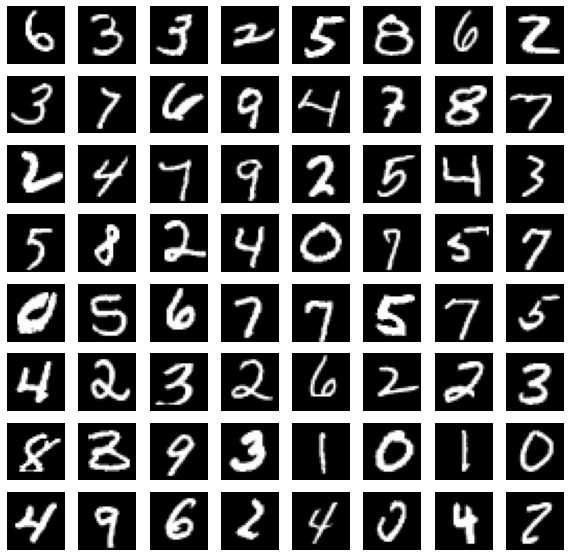

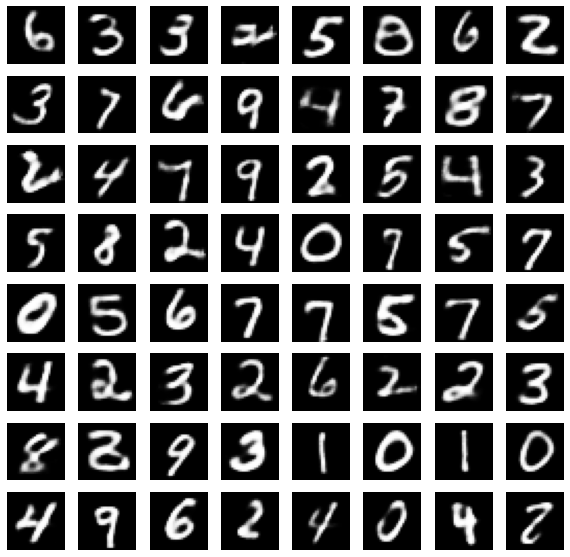

In [10]:
# Plot the first 64 data points of val_x using plots.plot_images()
###* put your code here (~1 line) *###
plots.plot_images(val_x[0:64], dim_x=28, dim_y=28, fig_size=(10,10))

# Run the first 64 data points in val_x through the auto-encoder to obtain reconstructed_val_x
###* put your code here (~1 line) *###
rec_val_x = ae_model.predict(val_x[0:64])

# Plot the reconstructed data
###* put your code here (~1 line) *###
plots.plot_images(rec_val_x[0:64], dim_x=28, dim_y=28, fig_size=(10,10))

### [Task 2b] (10 points) Exploring the latent space. Compute the average latent space representation of 0s and 8s in the validation data. Call these 'avg_zeros_latent' and 'avg_eights_latent' respectively. 

In [11]:
###* put your code here (~5-8 line) *###
zeros_idx = np.where(val_y == 0)[0]
eights_idx = np.where(val_y == 8)[0]

zeros_latent = enc_model.predict(val_x[zeros_idx])
eights_latent = enc_model.predict(val_x[eights_idx])

avg_zeros_latent = np.mean(zeros_latent, axis=0)
avg_eights_latent = np.mean(eights_latent, axis=0)

In [12]:
assert avg_zeros_latent.shape == (latent_width,) or avg_zeros_latent.shape == (latent_width,1)
assert avg_eights_latent.shape == (latent_width,) or avg_eights_latent.shape == (latent_width,1)

### We will look at the transition between 0 and 8 in the latent space.

In [13]:
def linear_exploration(source, target, num_steps):
    diff = target - source
    inc = diff / num_steps
    
    ret = np.zeros((num_steps, source.shape[0]))
    for i in range(0, num_steps):
        ret[i] = source + inc * i
        
    return ret

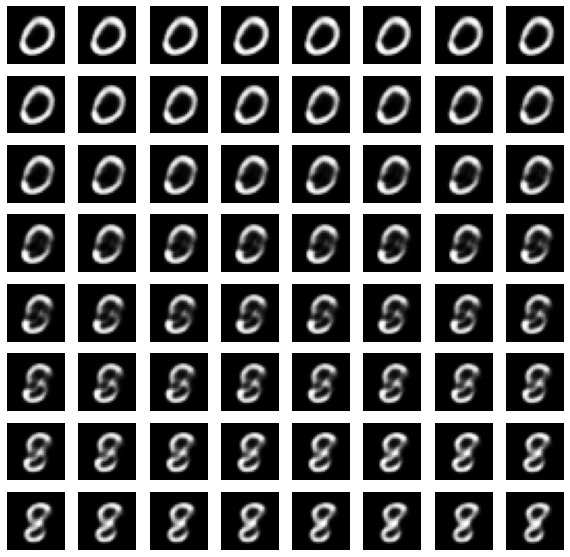

In [14]:
# Let's explore linearly
expl = linear_exploration(avg_zeros_latent, avg_eights_latent, 64)
expl_as_images = dec_model.predict(expl)
plots.plot_images(expl_as_images[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

## [Task 3] (25 points) Extracting Features. Let's use the autoencoder for feature extraction. Then we will train a classifier on the basis of the extracted features.

### [Task 3a] (5 points) Extract feature representations for train_x, val_x, and test_x using the AE. Name the new feature matrices 'fext_train_x', 'fext_val_x' , and 'fext_test_x'

In [15]:
###* put your code here (~3 lines) *###
fext_train_x = enc_model.predict(train_x)
fext_val_x = enc_model.predict(val_x)
fext_test_x = enc_model.predict(test_x)

In [16]:
assert fext_train_x.shape[1] == latent_width and fext_train_x.shape[1] == fext_val_x.shape[1]  and fext_train_x.shape[1] == fext_test_x.shape[1]

### [Task 3b] (20 points) Fill in the implementation of create_compile_classifier. You can use an architecture of your choice, but the model should be classifying digits from the features (latent space representation) extracted by the AE. Your classifier should get 95%+ accuracy.

In [17]:
def create_compile_classifier(latent_width=latent_width, num_outputs=10, verbose=True):
    name = 'Model-ExtFeatures'
    
    ###* put your code here (~10 lines) *###
    hidden_widths=[64, 32]
    
    model = keras.models.Sequential(name=name)
    
    model.add(Input(shape=(latent_width,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(Dense(hw, activation='relu', name='hidden_{}'.format(i)))
        
    model.add(Dense(num_outputs, activation='softmax', name='output'))
    
    opt = keras.optimizers.Adam(lr=0.001)
    
    if verbose:
        model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [18]:
# Train the classifier
name, classifier = create_compile_classifier(verbose=True)
    
max_epochs = 25
batch_size = 64

hist = classifier.fit(fext_train_x, train_y, epochs=max_epochs, batch_size=batch_size, validation_data=(fext_val_x, val_y))

Model: "Model-ExtFeatures"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 64)                3136      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 5,546
Trainable params: 5,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
938/938 [==============================] - 1s 1ms/step - loss: 1.3583 - accuracy: 0.5980 - val_loss: 0.4312 - val_accuracy: 0.8674
Epoch 2/25
938/938 [==============================] - 1s 1ms/step - loss: 0.3847 - accuracy: 0.8825 - val_loss: 0.3553 - val_accuracy: 0.8940
Epoch 3/25
938/938 [==============================] - 1s 1ms/step - loss: 0.3394 - accuracy: 

In [19]:
test_loss, test_acc = classifier.evaluate(fext_test_x, test_y, verbose=0)

print('[{}] Test loss: {:.5f}, test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))

[Model-ExtFeatures] Test loss: 0.15159, test accuracy: 95.320%


## [Task 4] (25 points) Sampling new data points. In this task, you will attempt to produce *new* images of digits using the auto-encoder and classifier.

### [Task 4a] (10 points) Briefly describe what you know about the range and distribution of the latent space of the AE (ae_model) trained in Task 1? (Hint: think about the architecture. What do you know about the latent space?)

In [20]:
###* put your answer here *###
#
# The latent space does not necessarily have some well-defined distribution that we know. 
# But, we do know that any valid latent space point must be a vector of latent_width real numbers 
# all in the range [0,1]. This is guaranteed because we use sigmoid activation at the last layer of the encoder.
#

### [Task 4b] (5 points) Given your answer to the previous question, provide a plausible distribution that you could easily sample from to obtain valid latent space points. For this you cannot use the data!

In [21]:
###* put your answer here *###
#
# Again, we don't know the distribution, but we could simply sample each coordinate of the latent space representation
# as a uniform random variable in [0,1]. This would ensure that at least all samples are valid.
#

### [Task 4c] (5 points) Complete the implementation of sample_new_digits() by sampling points from the distribution you mentioned in 4b. You should *not* use any data (train_x/y, val_x/y, test_x/y, etc.).

In [22]:
def sample_new_digits(dec_model, count, latent_width=latent_width):
    ### sample 'count' latent space points and store the resulting array in 'sampled_latent_space_points'
    ###* put your code here (~1-2 lines) *###
    sampled_latent_space_points = np.random.uniform(low=0.0, high=1.0, size=(count, latent_width,))
    
    return dec_model.predict(sampled_latent_space_points) # decode the sampled points

#### Let's produce new images and see what they look like.

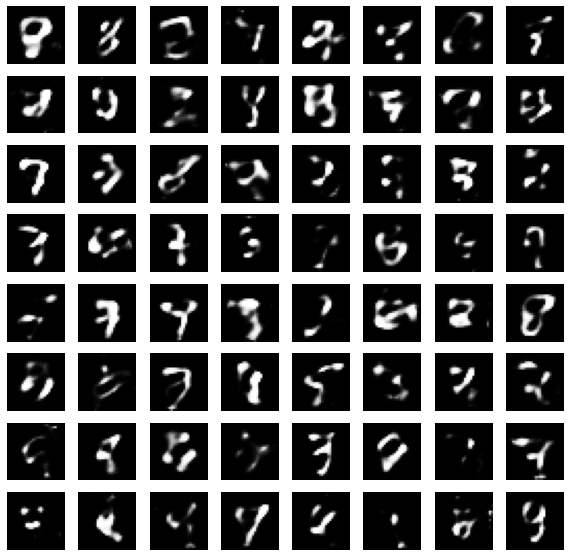

In [23]:
# generate 64 new images
sample_images = sample_new_digits(dec_model, 64, latent_width=latent_width)

# plot the produced images
plots.plot_images(sample_images[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

### [Task 4d] (5 points) Do the new images look like digits? If not, explain why not.

In [24]:
###* put your answer here *###
#
# No, they don't really look like digits. Some do, but most do not. The reason is that we don't know the AE's latent space distribution.
# There is nothing constraining the latent space of the autoencoder so its distribution could be weird/arbitrary.
#

## [CIS6930 Additional Task -- Task 5] (25 points): Variational AutoEncoders

### For this task, you will use the provided VAE implementation in nets.py. The goal is to train the model and use it to generate new samples.

### [Task 5a] (10 points) Fill in the implementation below to create the VAE and model and train it.

In [49]:
latent_width = 48

### Create a VAE using nets.create_simple_vae() then train it for at least 25 epochs.
### Make sure the latent width of the VAE is set to 48
###* put your code here (~2-4 lines) *###

vae_model, enc_model, dec_model = nets.create_simple_vae(latent_width=latent_width, verbose=False)
    
max_epochs = 50
batch_size = 200

hist = vae_model.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))

Epoch 1/50
300/300 [==============================] - 3s 9ms/step - loss: 0.2982 - binary_crossentropy: 0.2915 - mse: 0.0768 - val_loss: 0.2075 - val_binary_crossentropy: 0.1867 - val_mse: 0.0419
Epoch 2/50
300/300 [==============================] - 3s 9ms/step - loss: 0.2000 - binary_crossentropy: 0.1787 - mse: 0.0392 - val_loss: 0.1821 - val_binary_crossentropy: 0.1595 - val_mse: 0.0326
Epoch 3/50
300/300 [==============================] - 3s 9ms/step - loss: 0.1796 - binary_crossentropy: 0.1556 - mse: 0.0312 - val_loss: 0.1710 - val_binary_crossentropy: 0.1453 - val_mse: 0.0278
Epoch 4/50
300/300 [==============================] - 3s 10ms/step - loss: 0.1695 - binary_crossentropy: 0.1434 - mse: 0.0271 - val_loss: 0.1654 - val_binary_crossentropy: 0.1382 - val_mse: 0.0254
Epoch 5/50
300/300 [==============================] - 3s 10ms/step - loss: 0.1639 - binary_crossentropy: 0.1367 - mse: 0.0249 - val_loss: 0.1616 - val_binary_crossentropy: 0.1340 - val_mse: 0.0239
Epoch 6/50
300/300

### [Task 5b] (5 points) Similar to Task 2a, use plot_images() to plot the first 64 data points in the val_x. Then reconstruct val_x through the VAE and plot the first 64 data points of the reconstructed data. 

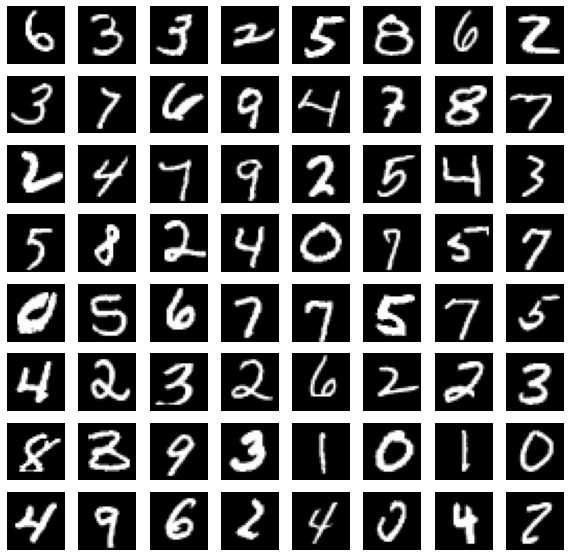

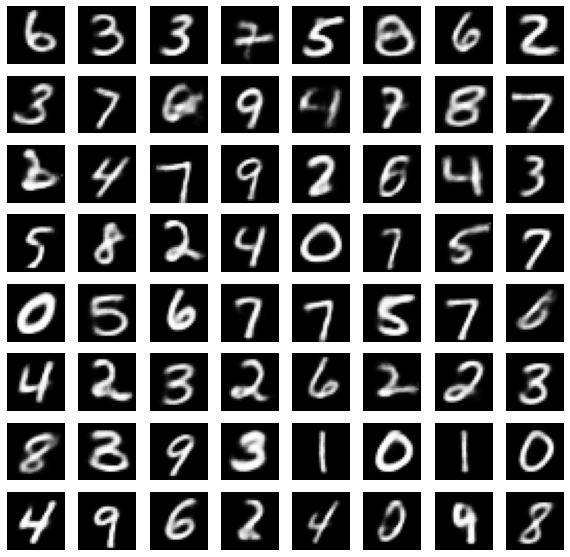

In [50]:
# Plot the first 64 data points of val_x using plots.plot_images()
###* put your code here (~1 line) *###
plots.plot_images(val_x[0:64], dim_x=28, dim_y=28, fig_size=(10,10))

# Run the first 64 data points in val_x through the VAE to obtain reconstructed_val_x
###* put your code here (~1 line) *###
rec_val_x = vae_model.predict(val_x[0:64])

# Plot the reconstructed data
###* put your code here (~1 line) *###
plots.plot_images(rec_val_x[0:64], dim_x=28, dim_y=28, fig_size=(10,10))

### [Task 5c] (5 points) What is the latent space distribution for the VAE?

In [51]:
###* put your answer here *###
#
# The latent space distribution is (approximately) isotropic gaussian with unit variance.
# In other words, a point/vector in the latent space is distributed as a standard normal random vector.
# This is enforced using the KL-divergence loss component during training.
#

### [Task 5d] (5 points) Complete the implementation below by sampling points from the distribution you mentioned in 5c. You should *not* use any data (train_x/y, val_x/y, test_x/y, etc.).

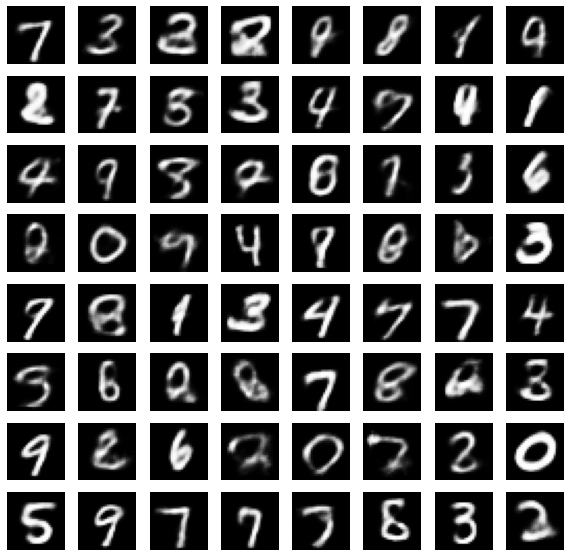

In [53]:
### You should sample 100 latent space points (according to the distribution you describe in 5c) and
### then you should decode these points into images (call this array 'sample_images').
###* put your code here (~1 line) *###
latent_space_points = tf.random.normal((100, latent_width))
sample_images = dec_model.predict(latent_space_points)


plots.plot_images(sample_images[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))